<center><h1><bold>Classification of Wildfire Casuses</bold></h1></center>

# R4 - Baseline Training and Evaluation using Naive Bayes

#### Importing necessary python libraries required for data wrangling
- <code>Pandas</code>: for data structutres and tools for effective data cleaning
<code>numpy</code>: for numerical and array-based operations
- <code>sklearn</code>: open source machine learning library for python
- <code>Matplotlib</code>: allow for graphical representation of the data set features

From <code>sklearn</code> we import
- <code>sklearn.naive_bayes</code>: provides three main types of Naive Bayes Classifiers including <code>Gaussian Naive Bayes</code>, <code>MultinominalNB</code>, <code>BernoulliNB</code>.
- <code>preprocessing</code>: to transform categorical features to numerical values for decision tree classifier
- <code>model_selection</code>: to split the data into training and test sets
- <code>metrics</code>: for the evaluation of the model performance

In [50]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

<h2>Downloading the Data</h2>
    To download the data, we will use pandas library to read it directly into a dataframe from a CSV file.

In [2]:
wildfire_data = pd.read_csv(r'C:\Users\Favour Sukat\OneDrive - Heriot-Watt University\SEMESTER 1(Septermber)\Data Mining and Machine Learning\group-coursework-bots-ahead\data\wildifire2.csv')
wildfire_data.head() 

,Unnamed: 0,FIRE_DAY,FIRE_MONTH,Fire_Duration,FIRE_SIZE,STATE,LATITUDE,LONGITUDE,NWCG_GENERAL_CAUSE,NWCG_CAUSE_CLASSIFICATION
0,0,Wednesday,February,0,0.10,CA,40.036944,-121.005833,Power generation/transmission/distribution,Human
1,1,Wednesday,May,0,0.25,CA,38.933056,-120.404444,Natural,Natural
2,2,Monday,May,0,0.10,CA,38.984167,-120.735556,Debris and open burning,Human
3,3,Monday,June,5,0.10,CA,38.559167,-119.913333,Natural,Natural
4,4,Monday,June,5,0.10,CA,38.559167,-119.933056,Natural,Natural


<h2>Preprocessing</h2>
Selecting the features to be used in the classifier
<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (data of <code>wildfire_data</code>) </li>
    <li> <b> Y </b> as the <b> response vector </b> (target) </li>
</ul>

The algorithm will be implemented without the feature <code>NWCG_GENERAL_CAUSE</code><br>
- We are excluding it because the feature contians our similar data to our target binary class which are the values <b>natural</b> and <b>human<b>

In [3]:
# excluding the target variable from our selection
X = wildfire_data[['FIRE_MONTH', 'Fire_Duration', 'FIRE_SIZE', 'STATE', 'LATITUDE', 'LONGITUDE']].values
X[0:5]

array([['February', 0, 0.1, 'CA', 40.03694444, -121.00583333],
       ['May', 0, 0.25, 'CA', 38.93305556, -120.40444444],
       ['May', 0, 0.1, 'CA', 38.98416667, -120.73555556],
       ['June', 5, 0.1, 'CA', 38.55916667, -119.91333333],
       ['June', 5, 0.1, 'CA', 38.55916667, -119.93305556]], dtype=object)

Some features in this dataset are categorical, such as **FIRE_MONTH** and **STATE**. Sklearn KNearestClassifier does not handle categorical variables.
 - We will transform the categorical features into numerical data using the <code>LabelEncoder()</code> from sklearn's preprocessing

In [6]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
states = ['CA', 'NM', 'OR', 'NC', 'WY', 'WA', 'MT', 'UT', 'AZ', 'SD', 'NV',
       'ID', 'MN', 'SC', 'OK', 'CO', 'MO', 'NE', 'MI', 'KY', 'OH', 'IN',
       'VA', 'IL', 'TN', 'GA', 'AK', 'TX', 'ND', 'WV', 'WI', 'NH', 'PA',
       'AR', 'FL', 'MS', 'AL', 'ME', 'VT', 'LA', 'KS', 'MD', 'NJ', 'MA',
       'NY', 'HI', 'CT', 'PR', 'RI', 'IA', 'DE']
le_month = preprocessing.LabelEncoder()
le_states = preprocessing.LabelEncoder()

# Fit the LabelEncoder to these categories
le_month.fit(months)
le_states.fit(states)

# Transform the column in the array X (e.g., column index 0 for month and 3 for state)
X[:, 0] = le_month.transform(X[:, 0])
X[:, 3] = le_states.transform(X[:, 3])

Viewing the array after the data has been trasformed

In [7]:
X[0:5]

array([[3, 0, 0.1, 4, 40.03694444, -121.00583333],
       [8, 0, 0.25, 4, 38.93305556, -120.40444444],
       [8, 0, 0.1, 4, 38.98416667, -120.73555556],
       [6, 5, 0.1, 4, 38.55916667, -119.91333333],
       [6, 5, 0.1, 4, 38.55916667, -119.93305556]], dtype=object)

#### Storing the target varible in Y

In [8]:
Y = wildfire_data['NWCG_CAUSE_CLASSIFICATION']
Y[0:6]

0      Human
1    Natural
2      Human
3    Natural
4    Natural
5    Natural
Name: NWCG_CAUSE_CLASSIFICATION, dtype: object

## Training and Testing
Now <code>train_test_split</code> will usually return 4 different parameters. We label them:<br>
X_train, X_test, Y_train, Y_test <br> <br>
The <code>train_test_split</code> will need the parameters: <br>
X, Y, test_size=0.3, and random_state=42. <br> <br>
- The <b>X</b> and <b>Y</b> are the arrays required before the split<br> 
- The <b>test_size</b> represents the ratio of the testing dataset; so 30% of the data will be used for testing<br>
- The <b>random_state</b> ensures that we obtain the same splits.
- We also use the <b>stratify</b> parameter to make sure that the data is evenly distributed

In [9]:
# stratify to ensure data is distributed evenly
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

## Modelling
### 1. Parameter
Naive Bayes algorithms generally have limited hyperparameters compared to other machine learning algorithms, which is one of the reasons they are simple and effecient.
- We will use `GridSearch with Cross-Validation` to optimize hyperparameters for the Naive Bayes model.
- The search will explore different combinations of:
  - **var_smoothing** in *GaussianNB*: a small constant is added to the each feature to avoid division by zero and handles cases with vey low actions.
  - **alpha** in *MultinomialNB*: this is the aditive smoothing parameter, **alpha=1.0** meaning it applies additive smoothing, which avoids zero probablities.
       -**bibarize** and **alpha** in *BernoulliNB*: used to binarize continuous features by applying a threshold. 
Now, we will see how each of these affects each Naive Bayes algorithms. 

a) GaussianNB

In [18]:
# Initializing the Gaussian NB
gnb = Pipeline([
    ('scaler', StandardScaler()),  # Normalize features
    ('classifier', GaussianNB())   # GaussianNB classifier
])
# Setting up hyperparameter grid
param_grid = {'classifier__var_smoothing': np.logspace(-9, -5, 5)}
gridsearch = GridSearchCV(gnb, param_grid, cv=5, scoring= 'accuracy')
gridsearch.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', GaussianNB())]),
             param_grid={'classifier__var_smoothing': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])},
             scoring='accuracy')

In [19]:
# Printing best parameter and score
print("Best Parameter: ", gridsearch.best_params_)
print("Best cross validation score: ", gridsearch.best_score_)

Best Parameter:  {'classifier__var_smoothing': 1e-09}
Best cross validation score:  0.8347745319884454


b) MultinomialNB

In [20]:
# Initializing MultinomialNB
mnb = Pipeline([
    ('discretizer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')),  # Discretize features
    ('classifier', MultinomialNB())  # MultinomialNB classifier
])
param_grid = {'classifier__alpha': [0.5, 1.0, 1.5, 2.0]}
gridSearchmnb = GridSearchCV(mnb, param_grid, cv=5, scoring='accuracy')
gridSearchmnb.fit(X_train, Y_train)

c:\Users\Favour Sukat\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\Favour Sukat\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\Favour Sukat\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\Favour Sukat\anaconda3\Lib\site-packages\sk

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('discretizer',
                                        KBinsDiscretizer(encode='ordinal',
                                                         strategy='uniform')),
                                       ('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [0.5, 1.0, 1.5, 2.0]},
             scoring='accuracy')

In [21]:
# Best parameters and score
print("MultinomialNB Best Params:", gridSearchmnb.best_params_)
print("MultinomialNB Best Score:", gridSearchmnb.best_score_)

MultinomialNB Best Params: {'classifier__alpha': 0.5}
MultinomialNB Best Score: 0.8341812768649216


c) BernoulliNB

In [23]:
bnb = Pipeline([
    ('binarizer', Binarizer()),  # Binarize features
    ('classifier', BernoulliNB())  # BernoulliNB classifier
])
param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'classifier__binarize': [0.0, 0.5, 1.0]
}
grid_searchbnb = GridSearchCV(bnb, param_grid, cv = 5, scoring='accuracy')
grid_searchbnb.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('binarizer', Binarizer()),
                                       ('classifier', BernoulliNB())]),
             param_grid={'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
                         'classifier__binarize': [0.0, 0.5, 1.0]},
             scoring='accuracy')

In [24]:
# Printing best parameter and score
print("Best Parameter: ", grid_searchbnb.best_params_)
print("Best cross validation score: ", grid_searchbnb.best_score_)

Best Parameter:  {'classifier__alpha': 0.1, 'classifier__binarize': 0.0}
Best cross validation score:  0.8424334750953595


We will be using **BernoulliNB** which has a slightly higher cross validation score.

## Prediction
- Let's make some <b>predictions</b> on the testing dataset and store it into a variable called <code>Y_pred</code>.

In [25]:
Y_pred = grid_searchbnb.predict(X_test)

#### Printing the prediction and the test data to visually compare results of the first 5 and last 5 values

In [26]:
print(Y_pred [0:5])
print(Y_test [0:5])

['Human' 'Natural' 'Human' 'Human' 'Human']
167511    Human
333524    Human
416014    Human
180646    Human
897540    Human
Name: NWCG_CAUSE_CLASSIFICATION, dtype: object


In [27]:
print(Y_pred [-5:])
print(Y_test [-5:])

['Natural' 'Human' 'Human' 'Natural' 'Natural']
613183      Human
323399      Human
72214       Human
92804     Natural
74358     Natural
Name: NWCG_CAUSE_CLASSIFICATION, dtype: object


## Model Evaluation
- **Accuracy Classification Score**: Measures the proportion of correct predictions
  - In binary classification (Human/Natural), it shows how often our model is correct
  - Perfect accuracy (1.0) means all predictions match true labels
  - However, with imbalanced classes, accuracy alone can be misleading

- **Classification Report**: Provides detailed per-class performance metrics
  - Precision: Proportion of correct positive predictions
  - Recall: Proportion of actual positives correctly identified
  - Support: Number of samples for each class

In [28]:
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy : ", accuracy)
print("Classification Report: \n", classification_report(Y_test,Y_pred))

Accuracy :  0.8424822785891195
Classification Report: 
               precision    recall  f1-score   support

       Human       0.89      0.92      0.91    234200
     Natural       0.53      0.45      0.49     46816

    accuracy                           0.84    281016
   macro avg       0.71      0.69      0.70    281016
weighted avg       0.83      0.84      0.84    281016



### Observations:
- The model have an accuracy of 0.85.
- It performs generally very well in prediciting **human** causes. It shows excellent  <code>recall</code> : 0.97 and high <code>f1-score</code>: 0.92 indicating a balanced performance for Human causes. 
- It is not as accurate when predicting **natural** causes and has a poor <code>recall</code>: 0.45 and <code>f1 score</code> of 0.49

## Confusion Matrix

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

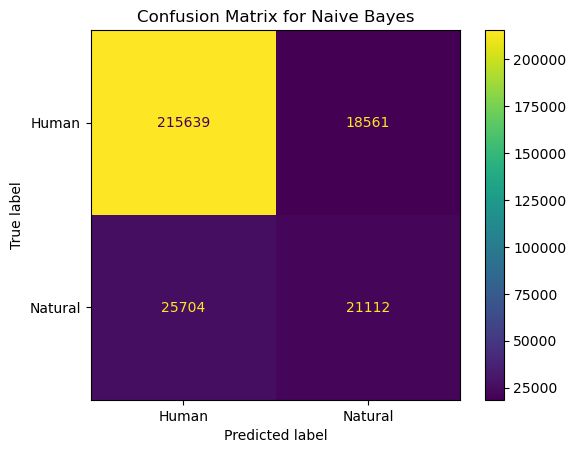

In [33]:
cm = confusion_matrix(Y_test, Y_pred)
# Plotting the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(grid_searchbnb, X_test,Y_test, cmap='viridis')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

## Applying SMOTE
- The accuracy is misleading which is evident in the confusion matrix with few true predictions for the minority class

## Retrain the Model

In [46]:

bnb_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('binarizer', Binarizer()),
    ('classifier', BernoulliNB())
])

X_temp, y_temp = bnb_smote.named_steps['smote'].fit_resample(X_train, Y_train)
print("\nClass distribution after SMOTE:")
print(pd.Series(y_temp).value_counts())

param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'classifier__binarize': [0.0, 0.5, 1.0]
}

# Fit the model
grid_searchbnb_sm = GridSearchCV(bnb_smote, param_grid, cv=5, scoring='accuracy')
grid_searchbnb_sm.fit(X_train, Y_train)


Class distribution after SMOTE:
NWCG_CAUSE_CLASSIFICATION
Human      546467
Natural    546467
Name: count, dtype: int64


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('binarizer', Binarizer()),
                                       ('classifier', BernoulliNB())]),
             param_grid={'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
                         'classifier__binarize': [0.0, 0.5, 1.0]},
             scoring='accuracy')

In [47]:
Y_pred_sm = grid_searchbnb_sm.predict(X_test)

In [48]:
accuracy = accuracy_score(Y_test, Y_pred_sm)
print("Accuracy : ", accuracy)
print("Classification Report: \n", classification_report(Y_test,Y_pred_sm))

Accuracy :  0.8424822785891195
Classification Report: 
               precision    recall  f1-score   support

       Human       0.89      0.92      0.91    234200
     Natural       0.53      0.45      0.49     46816

    accuracy                           0.84    281016
   macro avg       0.71      0.69      0.70    281016
weighted avg       0.83      0.84      0.84    281016



### Observations After SMOTE:
Despite applying SMOTE to balance our classes we observe minimal change in the model's performance compared to the imbalanced dataset.

This behavior can be explained by the fundamental characteristics of Naive Bayes:
1. **Feature Independence Assumption**: Naive Bayes assumes features are conditionally independent. This strong assumption remains a limitation regardless of class balance.
2. **Probability Distribution Focus**: Unlike KNN which benefits from balanced local neighborhoods, Naive Bayes makes decisions based on probability distributions. The synthetic samples created by SMOTE don't significantly alter these distributions.

### Key Findings
- Naive Bayes assumes that features are conditionally independent given the class labels which is not true in real- world dataset like this.
- Naive Byes is a linear classifier, so it cannot capture complex relationships in the data.